# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# 1D example

In [3]:
def f_1d_toy(x):
    if 2 <= x.item() <= 3:
        f = \
            -1600 * (x - 2.5) ** 5 - \
            2000 * (x - 2.5) ** 4 + \
            800 * (x - 2.5) ** 3 + \
            1020 * (x - 2.5) ** 2 

    elif 8.4 <= x.item() <= 8.40001:
        f = 1411.2 * (1 - 1e4 * (x - 8.4))

    elif 8.40001 <= x.item() <= 8.59999:

        f = x * 0

    elif 8.59999 <= x.item() <= 8.6:
        f = 1479.2 * (1e4 * (x - 8.6) + 1)

    else:
        f = 20 * x ** 2

    return f

In [4]:
xs = np.arange(-2, 10, 1e-3)
xs_torch = [torch.tensor([x]) for x in xs]
ys_torch = [f_1d_toy(x) for x in xs_torch]
ys = [y.item() for y in ys_torch]

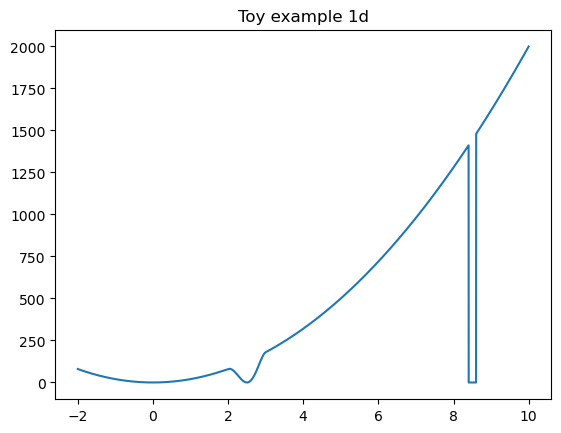

In [5]:
plt.plot(xs, ys)
plt.title('Toy example 1d')
plt.show()

In [6]:
torch.ones_like(torch.zeros(3)) * 0 / 0

tensor([nan, nan, nan])

In [7]:
def run_gd(func, lr, x_start_value, max_iter, return_null_if_fail=False):
    x = torch.tensor(x_start_value, requires_grad=True)
    optimizer = optim.SGD([x], lr=lr)
    x_hist_torch = []

    n_iter = 0

    while len(x_hist_torch) == 0 or \
        torch.norm(x - x_hist_torch[-1]) > 1e-6 and \
        n_iter < max_iter:

        x_hist_torch.append(x.detach().clone())

        optimizer.zero_grad()
        func(x).backward()

        optimizer.step()
        n_iter += 1

    x_hist_torch.append(x.detach().clone())

    if n_iter >= max_iter and return_null_if_fail:
        x_hist_torch.append(torch.zeros_like(x) / 0)

    return x_hist_torch

In [15]:
def plot_1d_gd(lr, start_point, max_iter=1e3):

    xs = np.arange(-2, 10, 1e-3)
    xs_torch = [torch.tensor([x]) for x in xs]
    ys_torch = [f_1d_toy(x) for x in xs_torch]
    ys = [y.item() for y in ys_torch]
    
    plt.style.use('default')
    plt.plot(xs, ys)

    x_hist_torch = run_gd(f_1d_toy, lr, [start_point], max_iter)
    y_hist_torch = [f_1d_toy(x) for x in x_hist_torch]
    x_hist = [x.item() for x in x_hist_torch]
    y_hist = [y.item() for y in y_hist_torch]

    plt.style.use('seaborn-dark-palette')
    plt.scatter(x_hist, y_hist, c=range(len(x_hist)))
    plt.title(f'Toy example 1d lr={lr}')
    plt.show()

/tmp/ipykernel_39651/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


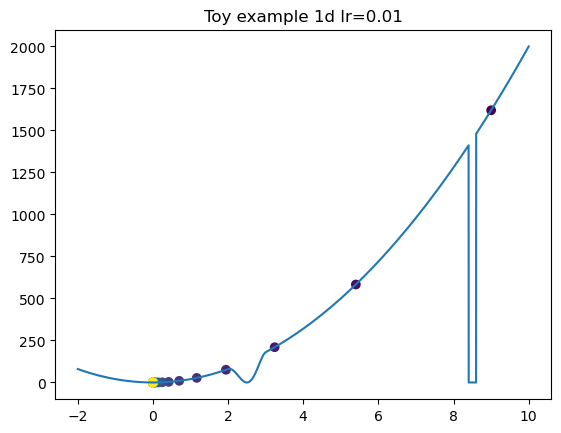

/tmp/ipykernel_39651/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


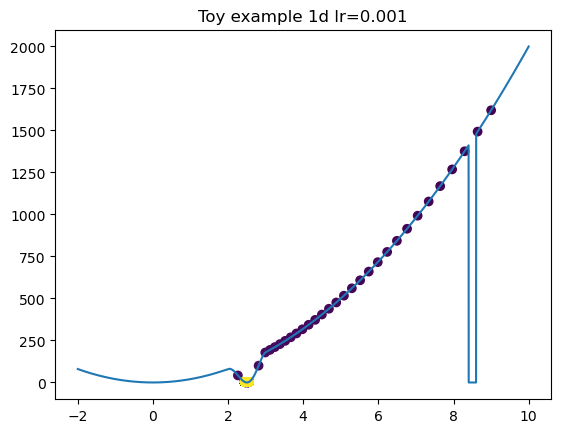

/tmp/ipykernel_39651/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


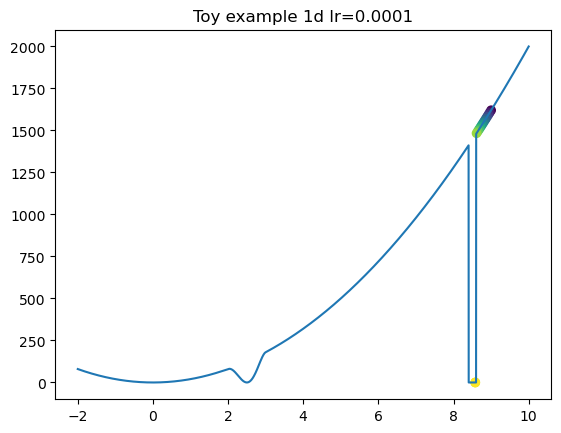

In [16]:
plot_1d_gd(1e-2, 9.)
plot_1d_gd(1e-3, 9.)
plot_1d_gd(1e-4, 9.)

In [17]:
import scipy.stats as ss
from itertools import product
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

In [18]:
lrs = np.logspace(-4, -2, 15)
x_starts = np.linspace(8.5, 10, 20)
x_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)

for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    x_ends[lr_i, x_start_i] = run_gd(f_1d_toy, lr, [x_start], 1e3, return_null_if_fail=True)[-1].item()


0it [00:00, ?it/s]

In [19]:
x_ends_df = pd.DataFrame(x_ends, columns=x_starts).assign(lrs=lrs)
x_ends_df = x_ends_df.melt(id_vars='lrs', var_name='x_start', value_name='x_end')
x_ends_df

,lrs,x_start,x_end
0,0.000100,8.5,8.500000e+00
1,0.000139,8.5,8.500000e+00
2,0.000193,8.5,8.500000e+00
3,0.000268,8.5,8.500000e+00
4,0.000373,8.5,8.500000e+00
...,...,...,...
295,0.002683,10.0,7.692986e-06
296,0.003728,10.0,8.508963e+00
297,0.005179,10.0,3.223516e-06
298,0.007197,10.0,1.838036e-06


In [20]:
def x_end_to_type(x):
    if np.isnan(x):
        return 'No convergence in 1000 iterations'

    if -1e-2 < x < 1e-2:
        return 'global min'
    
    elif -1e-2 < x - 2.5 < 1e-2:
        return 'local min'
    
    elif -8.4 < x < 8.6:
        return 'sharp local min near start'

    else:
        return 'something else' 


x_ends_df['x_end_type'] = x_ends_df['x_end'].apply(x_end_to_type)

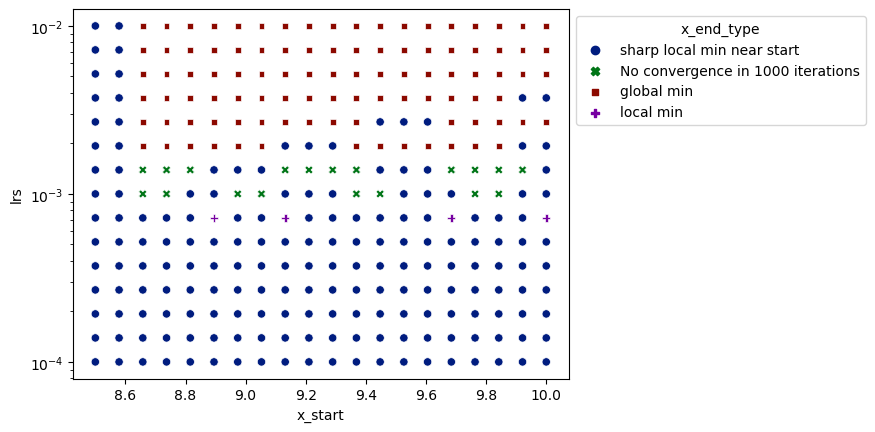

In [21]:
ax = sns.scatterplot(
    data=x_ends_df, 
    x='x_start', 
    y='lrs', 
    hue='x_end_type', 
    style='x_end_type',
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.yscale('log')
plt.show()

# 2D example

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [23]:
import torch.nn.functional as F

In [24]:
def f_2d_toy(x, y):
    f_A = x ** 2 + y ** 2
    f_B = 200 * \
        F.relu(torch.abs(x) - 1) * \
        F.relu(torch.abs(y) - 1) * \
        F.relu(2 - torch.abs(x)) * \
        F.relu(2 - torch.abs(y))

    return f_A - f_B

In [25]:
x = torch.linspace(-3, 3, 40)
y = torch.linspace(-3, 3, 40)

grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

In [26]:
grid_z = f_2d_toy(grid_x, grid_y)

In [58]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.05, [3., 2.5], max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()

In [59]:
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ],
)

fig.update_layout(
    title={
        'text': f'GD converged to flat minima lr=0.01', 
        'x':0.5,
        'xanchor': 'center',
    }
)

fig.show()

In [37]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.005, [3., 2.5], max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ]
)

fig.update_layout(
    title={
        'text': f'GD converged to sharp minima lr=0.005', 
        'x':0.5,
        'xanchor': 'center',
    }
)


fig.show()

In [82]:
lrs = np.logspace(-2, -1, 20)

x_starts = np.random.uniform(3, 4, size=(40, 2))
x_ends = np.zeros((len(lrs), len(x_starts), 2), dtype=float)
z_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)


for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    ends = run_gd(lambda x: f_2d_toy(x[0], x[1]), lr, x_start, 1e3)[-1]
    x_ends[lr_i, x_start_i] = ends.numpy()
    z_ends[lr_i, x_start_i] = f_2d_toy(ends[0], ends[1]).item()


0it [00:00, ?it/s]

In [83]:
z_ends_df = pd.DataFrame(z_ends, columns=[f'x_start_{i}' for i in range(len(x_starts))])
z_ends_df['lr'] = lrs

In [84]:
z_ends_df = z_ends_df.melt(id_vars='lr', value_vars=[f'x_start_{i}' for i in range(len(x_starts))])

In [85]:
z_ends_df['log_lr'] = np.log10(z_ends_df['lr']).round()

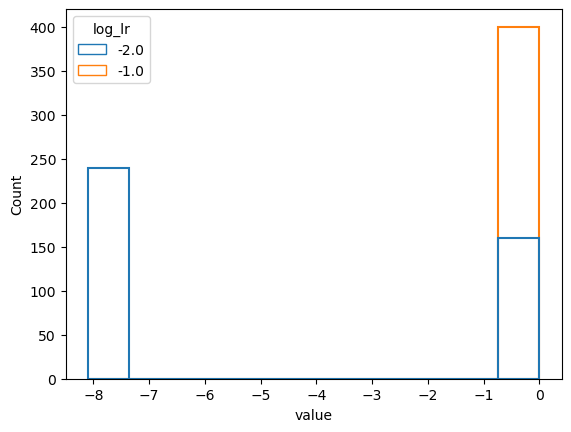

In [86]:
sns.histplot(data=z_ends_df, x='value', hue='log_lr', palette='tab10', fill=False)
plt.show()

In [87]:
def map_val_to_type(z):
    if z < -8:
        return 'sharp minima'

    elif -1e-2 < z < 1e-2:
        return 'flat minima'
    
    else:
        return 'did not converge'

z_ends_df['type_gd'] = z_ends_df['value'].apply(map_val_to_type)

In [88]:
frac_counter = z_ends_df.query('type_gd == "flat minima"').groupby('lr').size() / z_ends_df.groupby('lr').size()
frac_counter.fillna(0, inplace=True)
frac_counter = frac_counter.to_frame(name='fraction of flat minima').reset_index()

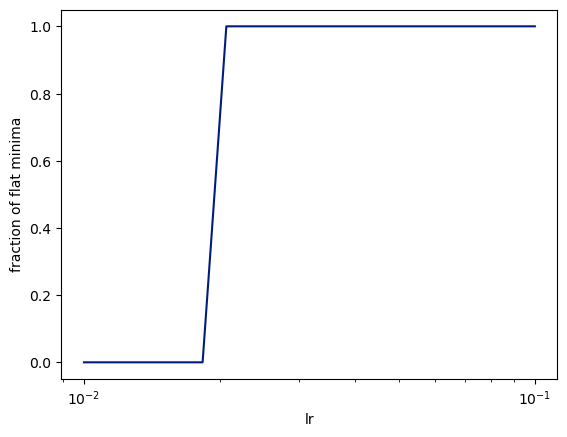

In [89]:
sns.lineplot(data=frac_counter, x='lr', y='fraction of flat minima')
plt.xscale('log')
plt.show()

# NN example

In [61]:
torch.cuda.is_available()

True

In [62]:
device = torch.device("cuda")

# Mnist

In [64]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 4
trainset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2
)

100%|██████████| 9912422/9912422 [00:00<00:00, 11266388.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46234997.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11960285.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9297476.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data CIFAR10

In [27]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 
    'cat', 'deer', 'dog', 
    'frog', 'horse', 'ship', 
    'truck'
)

Files already downloaded and verified
Files already downloaded and verified


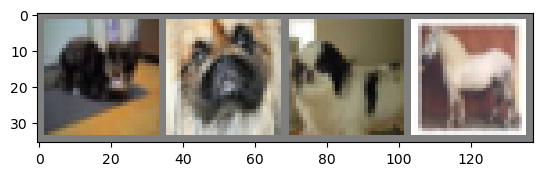

cat   dog   dog   horse


In [28]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# RESNET18

In [29]:
from torchvision.models import resnet18

# Train

In [30]:
import torch.optim as optim
from torch import nn

In [42]:
def train_resnet(lr, criterion, epochs=2):
    model = resnet18().to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    return model

In [54]:
def get_loss(model, loader, criterion, max_iter=None):
    running_loss = 0
    for i, data in enumerate(loader):
        if max_iter is not None and i >= max_iter:
                return running_loss / max_iter
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    return running_loss / 2000

In [55]:
criterion = nn.CrossEntropyLoss()

In [56]:
lrs = ss.loguniform(1e-5, 1e-1).rvs(5)
lrs.sort()

In [57]:
data = []
for lr in tqdm(lrs):
    model = train_resnet(lr=lr, criterion=criterion)
    train_loss = get_loss(model, trainloader, criterion, max_iter=2000)
    test_loss = get_loss(model, testloader, criterion, max_iter=2000)

    data.append([lr, train_loss, test_loss])

data

  0%|          | 0/5 [00:00<?, ?it/s]

[1,  2000] loss: 6.662
[1,  4000] loss: 5.522
[1,  6000] loss: 4.492
[1,  8000] loss: 3.661
[1, 10000] loss: 3.125
[1, 12000] loss: 2.777
[2,  2000] loss: 2.548
[2,  4000] loss: 2.444
[2,  6000] loss: 2.372
[2,  8000] loss: 2.328
[2, 10000] loss: 2.276
[2, 12000] loss: 2.243
[1,  2000] loss: 6.089
[1,  4000] loss: 4.055
[1,  6000] loss: 2.953
[1,  8000] loss: 2.548
[1, 10000] loss: 2.369
[1, 12000] loss: 2.289
[2,  2000] loss: 2.230
[2,  4000] loss: 2.183
[2,  6000] loss: 2.156
[2,  8000] loss: 2.133
[2, 10000] loss: 2.130
[2, 12000] loss: 2.114
[1,  2000] loss: 3.873
[1,  4000] loss: 2.317
[1,  6000] loss: 2.140
[1,  8000] loss: 2.094
[1, 10000] loss: 2.049
[1, 12000] loss: 2.012
[2,  2000] loss: 1.984
[2,  4000] loss: 1.936
[2,  6000] loss: 1.918
[2,  8000] loss: 1.932
[2, 10000] loss: 1.891
[2, 12000] loss: 1.896
[1,  2000] loss: 2.741
[1,  4000] loss: 2.074
[1,  6000] loss: 1.992
[1,  8000] loss: 1.942
[1, 10000] loss: 1.916
[1, 12000] loss: 1.865
[2,  2000] loss: 1.796
[2,  4000] 

[[1.4879684142996904e-05, 2.2243355418145656, 2.2227296844124793],
 [2.98334390485732e-05, 2.072482407659292, 2.086677043914795],
 [0.0001276227031336555, 1.8774340060949326, 1.872955478131771],
 [0.0004326364506172268, 1.6907730510830878, 1.7167002181708813],
 [0.0021965350427261194, 1.4753734055235983, 1.4881720896437765]]

In [58]:
data = pd.DataFrame(data, columns=['lr', 'train_loss', 'test_loss'])

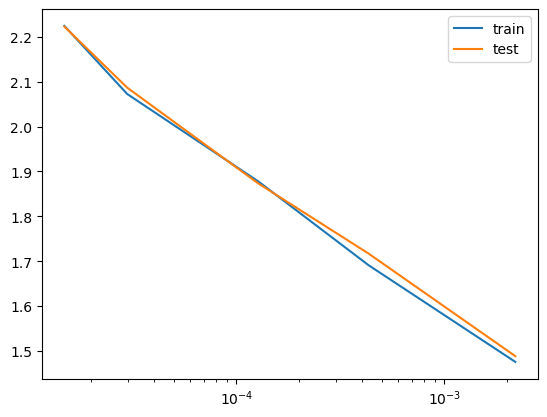

In [63]:
plt.plot(data['lr'], data['train_loss'], label='train')
plt.plot(data['lr'], data['test_loss'], label='test')
plt.legend()
plt.xscale('log')
plt.show()
